# Multivariate linear regression: Predicting the AQI (air quality index) using weather and pollution data for Aoti Zhongxin station - Beijing.

## Introduction
This data set includes air pollutants data from Aoti Zhongxin station(Beijing) taken from the Beijing Municipal Environmental Monitoring Center. Variables in this dataset include: time, measured concentrations of various pollutants, temperature, pressure, dew point, precipitation and wind information. The time period is: March 1st, 2013 - February 28th, 2017.  
AQI is a measurement for air quality that indicates how polluted the air currently is. It is calculated using the pollution levels of O3, PM2.5, PM10, CO, SO2 and NO2.  
We will use a multivariate linear regression model to answer the question "How do the chosen weather variables affect AQI in Beijing?".

## Methods & Results

In [1]:
# Load libraries, run before everything else
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("con2aqi")
library(con2aqi)
library(zoo) # for moving averages
install.packages("GGally")
library(GGally)
options(jupyter.plot_mimetypes = "image/png")  # Added by TA; we ran into 100mb file size limit problems

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
# Get weather + pollution data for the Aotizhongxin station in Beijing
download.file("https://raw.githubusercontent.com/DonkeyBlaster/dsci-100-2023w1-group43/main/PRSA_Data_Aotizhongxin_20130301-20170228.csv", "Aotizhongxin_data.csv")
air_quality_data <- read_csv("Aotizhongxin_data.csv") |>
    select(-station) |> # This just says "Aotizhongxin", no need to keep it around
    select(-No) # This is a continuously increasing counter, we don't need it either
head(air_quality_data, 3)
tail(air_quality_data, 3)

Rows: 35064 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): wd, station
dbl (16): No, year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, P...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2013,3,1,0,4,4,4,7,300,77,-0.7,1023.0,-18.8,0,NNW,4.4
2013,3,1,1,8,8,4,7,300,77,-1.1,1023.2,-18.2,0,N,4.7
2013,3,1,2,7,7,5,10,300,73,-1.1,1023.5,-18.2,0,NNW,5.6


year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2017,2,28,21,16,37,10,66,700,58,10.8,1014.2,-13.3,0,NW,1.1
2017,2,28,22,21,44,12,87,700,35,10.5,1014.4,-12.9,0,NNW,1.2
2017,2,28,23,19,31,10,79,600,42,8.6,1014.1,-15.9,0,NNE,1.3


AQI can be easily calculated with the "con2aqi" library (after wrangling). First, we remove any N/A values:

In [3]:
air_quality_data <- air_quality_data |> 
    na.omit() |> # AQI cannot be calculated with NA values\
    select(-wd) |>  # We don't know how to use this properly
    filter(year >= 2015, year <= 2016)  # We only want 2015-2016, measuring changed in 2014 and 2017 data is incomplete

# TODO: Explain why we are using 2015-2016 only, why we're removing wind direction, then remove the comments from my code

Our dataset consists of observations taken for the entirety of 2015, 2016 and for a portion of 2017. Measurements for the data from 2014 were taken using different methods and thus have been omitted from our analysis. Only data from 2015 and 2016 were used as they are complete, consistent and for the entire year.

Additionally, we need to wrangle the pollutant units into ones the library understands. Existing data are in ug/m^3, and the library wants the following units:
| PM2.5  | PM10   | SO2 | NO2 | CO  | O3  |
|--------|--------|-----|-----|-----|-----|
| ug/m^3 | ug/m^3 | ppb | ppb | ppm | ppm |

In [4]:
R = 0.082057366080960  # Gas constant for litres, atmospheres, kelvin, mols.
SO2_molecular_weight = 64.07  # g/mol
NO2_molecular_weight = 46.01  # g/mol
CO_molecular_weight = 28.01  # g/mol
O3_molecular_weight = 48.00  # g/mol
air_quality_data <- air_quality_data |>
    # PV = nRT formula rearranged to V = RT/P, n=1.
    mutate(volume = R * (273.2 + TEMP) / (PRES/1013)) |>   # Convert temp to Kelvin, pressure to atmospheres
    mutate(so2_ppb = volume * SO2 / SO2_molecular_weight) |>
    mutate(no2_ppb = volume * NO2 / NO2_molecular_weight) |>
    # Multiply by div by 1000 for ppb -> ppm
    mutate(co_ppm = volume * CO / CO_molecular_weight / 1000) |>
    mutate(o3_ppm = volume * O3 / O3_molecular_weight / 1000)
head(air_quality_data, 3)
tail(air_quality_data, 3)

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,volume,so2_ppb,no2_ppb,co_ppm,o3_ppm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,1,1,0,13,50,19,29,500,28,-1,1027,-22.4,0,4.4,22.03153,6.533465,13.88643,0.3932798,0.01285173
2015,1,1,1,11,30,15,31,600,27,-1,1027,-23.7,0,5.6,22.03153,5.157999,14.84411,0.4719357,0.01239274
2015,1,1,2,13,33,16,32,600,26,-1,1028,-23.7,0,4.2,22.01010,5.496513,15.30805,0.4714766,0.01192214


year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,volume,so2_ppb,no2_ppb,co_ppm,o3_ppm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,12,31,21,409,444,9,163,5300,3,-3,1022.1,-5.3,0,0.9,21.97450,3.086788,77.84923,4.157974,0.001373406
2016,12,31,22,451,483,9,147,5000,3,-3,1022.7,-5.0,0,0.1,21.96161,3.084977,70.16640,3.920315,0.001372600
2016,12,31,23,472,504,9,140,5400,3,-4,1022.6,-5.7,0,0.9,21.88247,3.073860,66.58434,4.218683,0.001367654


Next, we need to calculate moving averages for the concentrations, as per [the specification](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf). Each pollutant has a different period required, shown below:
| PM2.5    | PM10     | SO2      | NO2    | CO      | O3           |
|----------|----------|----------|--------|---------|--------------|
| 24 hours | 24 hours | 1 hour   | 1 hour | 8 hours | 1 or 8 hours |


In [5]:
air_quality_data <- air_quality_data |>
    mutate(pm2.5_24hour = zoo::rollmean(PM2.5, k = 24, fill = NA, align = "right")) |>
    mutate(pm10_24hour = zoo::rollmean(PM10, k = 24, fill = NA, align = "right")) |>
    mutate(co_8hour = zoo::rollmean(co_ppm, k = 8, fill = NA, align = "right")) |>
    mutate(o3_8hour = zoo::rollmean(o3_ppm, k = 8, fill = NA, align = "right"))  # For o3 specifically, con2aqi allows us to choose 1 or 8 hours.
    # We're using 8 hours as the 1-hour window does not allow for reporting of AQI values less than 101.
head(air_quality_data, 26)

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,⋯,WSPM,volume,so2_ppb,no2_ppb,co_ppm,o3_ppm,pm2.5_24hour,pm10_24hour,co_8hour,o3_8hour
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,1,1,0,13,50,19,29,500,28,⋯,4.4,22.03153,6.533465,13.886425,0.3932798,0.0128517269,NA,NA,NA,NA
2015,1,1,1,11,30,15,31,600,27,⋯,5.6,22.03153,5.157999,14.844110,0.4719357,0.0123927367,NA,NA,NA,NA
2015,1,1,2,13,33,16,32,600,26,⋯,4.2,22.01010,5.496513,15.308046,0.4714766,0.0119221377,NA,NA,NA,NA
2015,1,1,3,10,29,10,25,500,31,⋯,4.4,21.98871,3.431982,11.947789,0.3925154,0.0142010423,NA,NA,NA,NA
2015,1,1,4,12,25,14,33,700,24,⋯,1.4,21.95059,4.796446,15.743742,0.5485689,0.0109752966,NA,NA,NA,NA
2015,1,1,5,12,24,10,34,600,23,⋯,1.1,21.64455,3.378266,15.994669,0.4636462,0.0103713470,NA,NA,NA,NA
2015,1,1,6,6,18,4,19,500,34,⋯,1.6,21.58480,1.347576,8.913525,0.3853053,0.0152892357,NA,NA,NA,NA
2015,1,1,7,11,22,7,25,500,28,⋯,2.0,21.48314,2.347152,11.673084,0.3834906,0.0125318341,NA,NA,0.4387773,0.012566920
2015,1,1,8,12,20,11,49,600,10,⋯,0.9,21.60580,3.709440,23.009872,0.4628161,0.0045012084,NA,NA,0.4474694,0.011523105


Finally, we calculate AQI for each pollutant.

In [6]:
# This cell takes a while.
air_quality_data <- air_quality_data |>
    na.omit() |>  #  We will remove all rows with NA first.
    mutate(pm2.5_aqi = con2aqi(pollutant = "pm25", con = pm2.5_24hour)) |>
    mutate(pm10_aqi = con2aqi(pollutant = "pm10", con = pm10_24hour)) |>
    mutate(so2_aqi = con2aqi(pollutant = "so2", con = so2_ppb)) |>
    mutate(no2_aqi = con2aqi(pollutant = "no2", con = no2_ppb)) |>
    mutate(co_aqi = con2aqi(pollutant = "co", con = co_8hour)) |>
    mutate(o3_aqi = con2aqi(pollutant = "o3", con = o3_8hour, type = "8h"))
head(air_quality_data)

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,⋯,pm2.5_24hour,pm10_24hour,co_8hour,o3_8hour,pm2.5_aqi,pm10_aqi,so2_aqi,no2_aqi,co_aqi,o3_aqi
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,1,2,0,109,134,49,100,2600,2,⋯,42.20833,65.75000,1.308896,0.0050328119,118,57,24,45,15,5
2015,1,2,1,111,139,60,102,2700,2,⋯,46.29167,69.45833,1.482674,0.0026420505,128,59,30,46,17,3
2015,1,2,2,101,123,51,93,2400,2,⋯,50.04167,73.33333,1.595665,0.0010233792,137,61,25,42,19,1
2015,1,2,3,72,102,32,88,1700,2,⋯,52.50000,76.20833,1.621605,0.0009067614,143,62,16,39,19,1
2015,1,2,4,48,82,26,77,1300,2,⋯,54.08333,78.41667,1.613087,0.0009078973,147,63,13,35,19,1
2015,1,2,5,25,48,18,54,900,10,⋯,54.62500,79.37500,1.534301,0.0013602461,149,64,9,25,18,2


Because AQI is reported daily as the highest of the individual pollutant AQIs, we can obtain one final AQI value per day.

In [7]:
air_quality_data <- air_quality_data |>
    rowwise() |>  # This is required for the max function to read row-by-row
    mutate(aqi = max(pm2.5_aqi:o3_aqi))
air_quality_data$pollutant_index <- max.col(air_quality_data |> select(pm2.5_aqi:o3_aqi))
air_quality_data <- air_quality_data |>
    mutate(pollutant = colnames(air_quality_data[24 + pollutant_index]))

head(air_quality_data)
# Do not modify air_quality_data from this point onwards! It contains all original and calculated information. Duplicate frame if other modifications are needed.

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,⋯,o3_8hour,pm2.5_aqi,pm10_aqi,so2_aqi,no2_aqi,co_aqi,o3_aqi,aqi,pollutant_index,pollutant
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
2015,1,2,0,109,134,49,100,2600,2,⋯,0.0050328119,118,57,24,45,15,5,118,1,pm2.5_aqi
2015,1,2,1,111,139,60,102,2700,2,⋯,0.0026420505,128,59,30,46,17,3,128,1,pm2.5_aqi
2015,1,2,2,101,123,51,93,2400,2,⋯,0.0010233792,137,61,25,42,19,1,137,1,pm2.5_aqi
2015,1,2,3,72,102,32,88,1700,2,⋯,0.0009067614,143,62,16,39,19,1,143,1,pm2.5_aqi
2015,1,2,4,48,82,26,77,1300,2,⋯,0.0009078973,147,63,13,35,19,1,147,1,pm2.5_aqi
2015,1,2,5,25,48,18,54,900,10,⋯,0.0013602461,149,64,9,25,18,2,149,1,pm2.5_aqi


In [8]:
set.seed(7777)
# Retrieve training and testing splits
aqd_split <- initial_split(air_quality_data, prop = 0.75, strata = aqi)
aqd_train <- training(aqd_split)
aqd_test <- testing(aqd_split)
head(aqd_train)

year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,⋯,o3_8hour,pm2.5_aqi,pm10_aqi,so2_aqi,no2_aqi,co_aqi,o3_aqi,aqi,pollutant_index,pollutant
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
2015,1,6,10,14,18,29,26,700,29,⋯,0.01168598,73,57,15,12,6,11,73,1,pm2.5_aqi
2015,1,6,11,16,18,19,18,800,40,⋯,0.01196067,60,53,10,9,7,12,60,1,pm2.5_aqi
2015,1,6,12,12,12,14,12,700,48,⋯,0.01276975,53,48,8,6,7,12,53,1,pm2.5_aqi
2015,1,6,13,10,10,12,10,700,49,⋯,0.01368981,49,43,7,5,7,13,49,1,pm2.5_aqi
2015,1,6,14,21,32,15,35,800,32,⋯,0.01372741,47,39,8,17,7,13,47,1,pm2.5_aqi
2015,1,6,15,22,48,12,33,800,36,⋯,0.01481475,47,35,7,16,7,14,47,1,pm2.5_aqi


In [9]:
colnames(aqd_train)

[1] "year"            "month"           "day"             "hour"           
 [5] "PM2.5"           "PM10"            "SO2"             "NO2"            
 [9] "CO"              "O3"              "TEMP"            "PRES"           
[13] "DEWP"            "RAIN"            "WSPM"            "volume"         
[17] "so2_ppb"         "no2_ppb"         "co_ppm"          "o3_ppm"         
[21] "pm2.5_24hour"    "pm10_24hour"     "co_8hour"        "o3_8hour"       
[25] "pm2.5_aqi"       "pm10_aqi"        "so2_aqi"         "no2_aqi"        
[29] "co_aqi"          "o3_aqi"          "aqi"             "pollutant_index"
[33] "pollutant"

# TODO: We're going to do the pair plot analysis here to determine which variables are useful. Someone please fill details

Looking at a pair plot allows us to look at the correlation between each individual predictor and overall AQI and then you can we can decide which ones would be a better choice to use in the final model.

,TEMP,PRES,DEWP,RAIN,WSPM,aqi
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.0052255,0.7076001,-1.702690,-0.08346706,0.1727491,-1.044135
2,-0.9194986,0.7076001,-1.805926,-0.08346706,-0.6499448,-1.231322
3,-0.9194986,0.5140315,-1.864919,-0.08346706,0.3372878,-1.332115
4,-0.9194986,0.6108158,-1.864919,-0.08346706,1.3245205,-1.389710
5,-0.9194986,0.6108158,-1.931286,-0.08346706,1.4890593,-1.418508
6,-0.8337717,0.9011686,-1.805926,-0.08346706,1.3245205,-1.418508


Warning message in warn_deprecated(!missing(legends), "legends"):
“'legends' will be deprecated in future versions.  Please remove it from your code”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


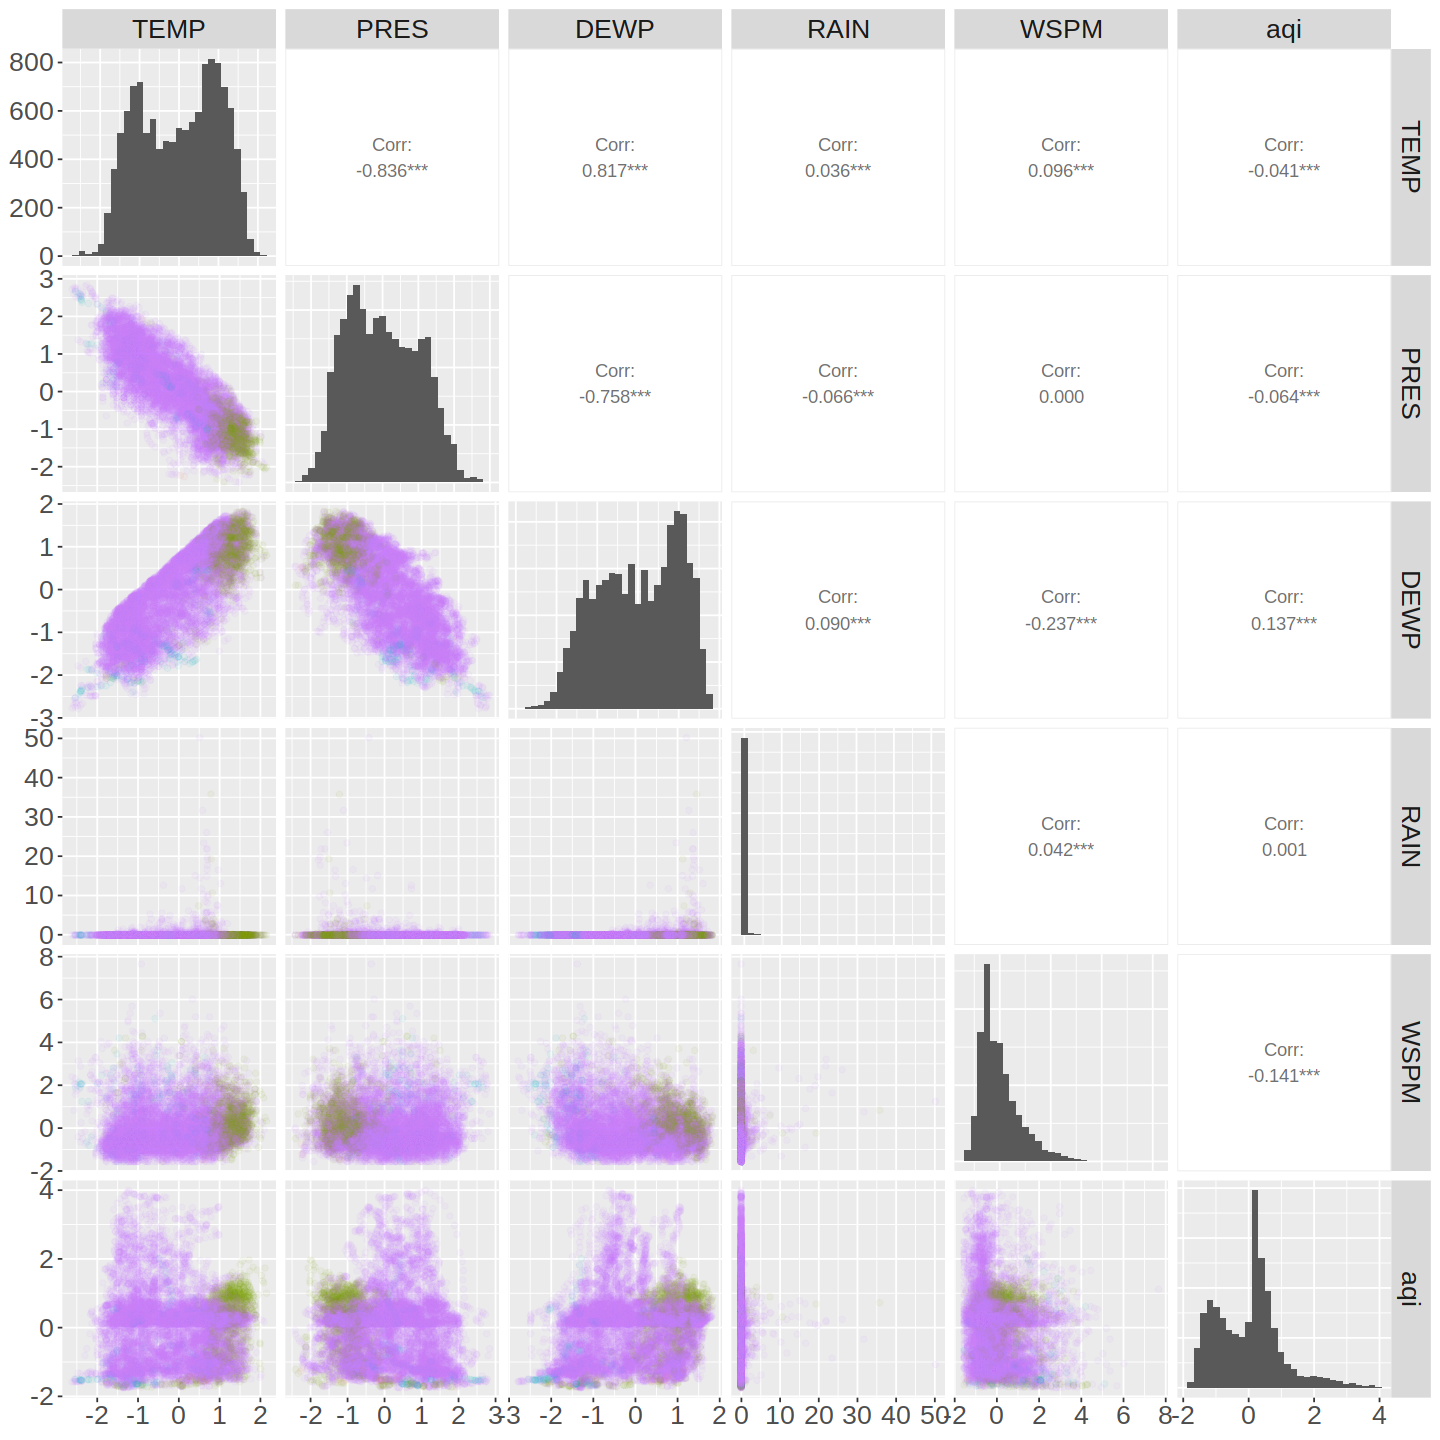

In [10]:
options(repr.plot.width = 12, repr.plot.height = 12)
aqd_pairplot <- aqd_train |>
    select(TEMP:WSPM, aqi) |>
    scale() |>
    as.data.frame()

head(aqd_pairplot)

ggpairs(aqd_pairplot,
        # directly stealing the color from aqd_train$pollutant is fine because we make no modification to row count on either dataframe, they will still line up
        lower = list(continuous = wrap('points', alpha = 0.05), mapping = aes(color = aqd_train$pollutant)),
        diag = list(continuous = "barDiag")) +
    theme(text = element_text(size = 20))

# TODO: it is clear that TEMP and DEWP are very closely related, blah blah blah, we only pick one of them, so we have PRES DEWP WSPM, rain looks pretty terrible, blah blah, and so on

The TEMP and DEWP predictors show multicollinearity. This means that when two predictors are strongly correlated with each other, both have a significantly similar impact on the overall prediction. This makes it so that we don't need to include both in the final analysis as it would be equivalent to using two of the same variable in our prediction. TEMP and DEWP have a correlation coefficient of 0.834, and we deem this high enough to see fit to include only one in the final model: in this case, DEWP. The reason why we chose to use DEWP instead of TEMP is because the relevant research shows that DEWP has a more consistent relationship with the levels of pollutants than TEMP. Also, judging by the pair plot above, rain has almost no correlation with AQI(with a correlation coefficient of less than 0.01) and thus was not used in the final predictor model. We ultimately decided to use PRES, DEWP and WSPM as our main predictors.

# TODO: let's do the linear regression with PRES and DEWP and WSPM, predicting overall aqi now. We still have aqd_train and aqd_test, add details here

We now use our (75:25) training and testing splits we created earlier. The training set is used to train a multivariate linear regression model. Here we use the linear_reg() function to do this and will use the testing data in the code cell below this one to evaluate the accuracy of our model.

In [11]:
lm_spec <- linear_reg () |>
    set_engine("lm") |>
    set_mode("regression")
aqi_recipe <- recipe(aqi ~ PRES + DEWP + WSPM, data = aqd_train)
aqi_fit <- workflow() |>
    add_model(lm_spec) |>
    add_recipe(aqi_recipe) |>
    fit(data = aqd_train)

# TODO: now we evaluate accuracy of model (it's pretty bad)

Here we evaluate our model tuned using our training data, by testing it against the untouched testing split. We find that the RMSPE value is 66.74, which represents a high error considering that most AQI values range from 0 to 500.

In [12]:
aqi_rmspe <- aqi_fit |>
    predict(aqd_test) |>
    bind_cols(aqd_test) |>
    metrics(truth = aqi, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()
aqi_rmspe

[1] 66.74037

# TODO: This model is pretty terrible, RMSPE (measuring accuracy against never-seen-before data) is \<number>. Each aqi classification bracket is only 50

The multivariate linear regression model that we've come up with is not sufficiently accurate. AQI is categorized into different levels and each classification bracket has a range of 50 to 100. 69.1 is too high a value to reliably predict within the correct bracket.

# TODO: What if we did it on the one pollutant that looks decent? here is the pairplot for individuals

Because we've come to realize that our model does not predict overall AQI levels reliably, we might start investigating correlations between our predictors and invidual pollutants. We've seen from the pairplots earlier that some pollutants correlate better with our predictors; O3 being the most consistent and pm2.5 being the least consistent. This means that our model would do be better suited to predict pollution levels for a select few pollutants(such as O3) more so than others.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


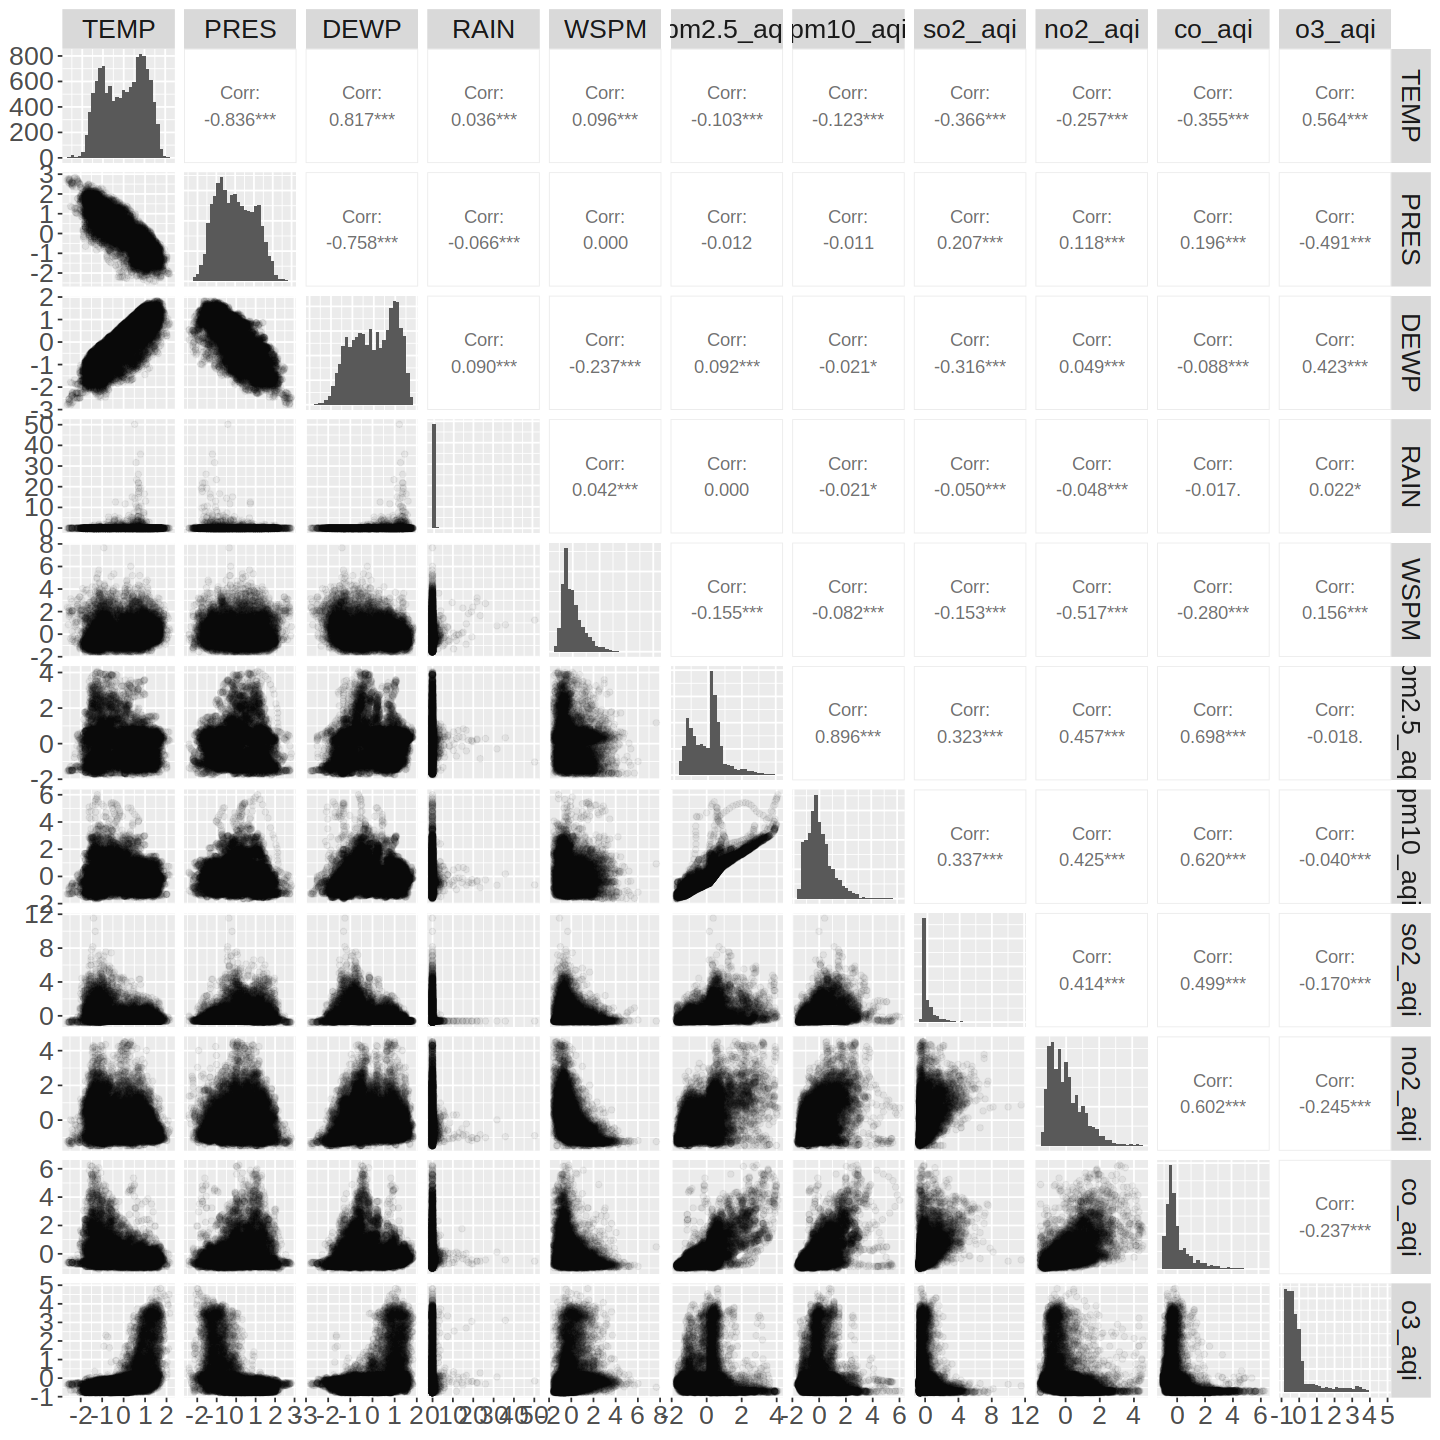

In [13]:
aqd_pairplot <- aqd_train |>
    select(TEMP:WSPM, pm2.5_aqi:o3_aqi) |>
    na.omit() |>
    scale() |>
    as.data.frame()
ggpairs(aqd_pairplot,
        lower = list(continuous = wrap('points', alpha = 0.05)),
        diag = list(continuous = "barDiag")
    ) +
    theme(text = element_text(size = 20))

# TODO: This is pretty good, within the 50-aqi bracket

The RMSPE value we got above when using our model to predict O3 levels was relatively low. This means that our model is able to reliably predict pollutant levels for O3 at least more so, in comparison to when used for other pollutants.

The RMSPE value we got above when using our model to predict O3 levels was relatively low. This means that our model is able to reliably predict pollutant levels for O3 at least more so, in comparison to when used for other pollutants.## Method
We will carry out a multivariate linear regression analysis on our data, to predict AQI based on weather conditions. We chose this method because:
* Knn would be very slow for such a large dataset
* We can have more confidence in our model for predictions where weather conditions are slightly beyond the range of inputs (more extreme weather)
* The regression equation shows a mathematical relationship – quantifies the relative contribution of each predictor    

Before creating our model, we will consider each variable, and their relationships, as follows:
* Wind direction is given in the dataset, but disregarded as it is not numerical 
* The dataset is large - any outliers are not likely to strongly affect our results
* We will assess the relationships between our weather variables (by producing pairwise scatter plots), to identify correlations between them and avoid multicollinearity.



## Discussion

Our final model produces a regression equation of *insert here*. If all the predictor variables (Dew point, pressure, wind speed) were zero, AQI would be *. This is an impossible value for AQI, as it cannot be negative, however air pressure at the Earth’s surface would never reach zero, which explains how the model can end up giving a realistic result. The coefficients of this equation mean that a * increase in dew point temperature, a * increase in pressure, or a * decrease in wind speed would lead to a one unit increase in the AQI. The error term in this equation is *. 
The RMSPE indicates that the predicted AQI is, on average, * units away from its true value when the model is tested on data is has not seen before. In the context of our model, this represents a relatively poor prediction. AQI values can be classified to find which level of pollution is present, as shown in the table below.

<img src="aqi_levels.png"/>

(https://www.airnow.gov/aqi/aqi-basics/)  

Each AQI band is only 50 units wide, so a RMSPE of * is very poor, as this would not even predict the correct class. Ideally, the model would have a RMSPE of less than 25, as this would normally predict in the correct class (an error of 25 units in each way should, on average, predict correctly within a class width of 50). Should this model be improved (and RMSPE reduced), an additional step to return AQI level would make the model more user-friendly, as *figure above* can give health recommendations based on AQI level, which is easier to interpret than the raw score.  
  
The coefficients for pressure and wind speed show the relationships that we would expect to AQI, whereas dew point shows the opposite to what would be expected.
The pressure coefficient shows a positive correlation with AQI, meaning that an increase in air pressure will cause AQI to increase (i.e. worse air quality). This relationship is explained by theory, as high-pressure systems often lead to stagnating of air, which allows pollutants to accumulate, leading to poor air quality (Chen et al.). The opposite is true in low pressure systems, where the weather is generally associated with higher precipitation levels and wind speeds – which will both lead to pollutants being washed out of the air (Zhang et al.).
The wind speed coefficient shows a negative correlation with AQI, meaning that increasing wind speed decreases AQI (i.e. improves air quality). This relationship is as expected, as higher wind speeds mean there is greater movement of air, and therefore greater dispersal of pollutants, leading to improved air quality (Liu et al.). When wind speed is low, mixing within the atmosphere is limited, meaning pollutants can accumulate and cause increases in AQI.
The dew point coefficient shows a positive correlation with AQI, which indicates that increasing dew point increases AQI. This relationship is not what would be expected from our prior research. Dew point is the temperature at which air becomes saturated, and water droplets start to condense. Below this temperature, clouds will form, often with pollutant particles as condensation nuclei, and subsequently precipitation will remove these pollutants from the air (Xu and Zhu). However, this process also depends on air temperature and humidity (Xu et al.), which may explain why the relationship seen in the final model may not be what is expected.
Overall, our model gives us a relatively high RMSPE. There is a significant amount of published literature detailing the impacts of different weather variables on air pollution, so we would have expected the model to predict better than it did. However, there are some improvements and changes we could make in order to try and create a model with more accurate predictions, as explained below.


### Limitations and areas for improvement
Early on in our work, we chose to disregard the wind direction variable for this project, as it was not numeric. However, this could have important implications for air quality, as it will bring air masses in from different locations. In Beijing, the city is surrounded by areas with different geographies – ranging from mountainous regions to high polluting urban areas – and air blowing from these areas will have very different initial pollution levels (Liang et al.). Wind direction can also impact precipitation levels – moist air masses blowing in from the ocean will bring higher levels of rainfall (particularly considering the presence of monsoons in the area), which is likely to reduce air pollutants (Ding et al.). We didn’t include rain as a predictor on its own, as it showed very little correlation, however including wind direction may represent some of the impacts it has.  
One way to include wind direction in the model would be to create dummy variables, which each hold a binary value of 0 or 1. We would create one fewer variables than categories (i.e. 7 variables if we used all cardinal and intercardinal directions), as a zero in all 7 of these would indicate it must be the 8th category. This category will become the reference category – the effects of all the other wind directions are shown relative to this one. When dummy variables are used, each wind direction will have a related coefficient, which will only become relevant when that wind direction is ‘1’. This allows the predicted AQI value to be scaled based on wind direction, which would likely lead to an improvement in the predicting power of the model.  
  
Another limitation of our model is that our dataset only includes weather variables. Whilst weather does significantly affect air quality, there are other factors that affect pollutant levels too. One of the main controls on air pollution levels in China is the use of fossil fuels, particularly in energy and transportation industries (Sarwar et al.). Weather can strongly influence which pollutants remain in (or are removed from) the atmosphere, but a huge part of the AQI score is reliant on which pollutants are released into the atmosphere in the first place. This was made particularly apparent during the COVID-19 pandemic, where lockdowns and their associated industry slowdowns led to notable improvements in air quality in China (X. Xu et al.). These air quality changes can confidently be attributed to human factors, rather than weather. The AQI prediction model could potentially be improved by sourcing further data that allows the inclusion of a variable (or variables) that represents the human impacts on air pollution, in addition to the existing weather variables.


## References for discussion so far
Chen, Z.H., et al. “Relationship between Atmospheric Pollution Processes and Synoptic Pressure Patterns in Northern China.” Atmospheric Environment, vol. 42, no. 24, 6 Dec. 2023, pp. 6078–6087, https://doi.org/10.1016/j.atmosenv.2008.03.043. Accessed 16 Nov. 2020.  

Ding, A. J., et al. “Tropospheric Ozone Climatology over Beijing: Analysis of Aircraft Data from the MOZAIC Program.” Atmospheric Chemistry and Physics, vol. 8, no. 1, 4 Jan. 2008, pp. 1–13, https://doi.org/10.5194/acp-8-1-2008. Accessed 6 Dec. 2023.  

Liang, Xuan, et al. “Assessing Beijing’s PM 2.5 Pollution: Severity, Weather Impact, APEC and Winter Heating.” Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences, vol. 471, no. 2182, Oct. 2015, p. 20150257, https://doi.org/10.1098/rspa.2015.0257. Accessed 6 Dec. 2023.  

Liu, Yansui, et al. “Exploring the Relationship between Air Pollution and Meteorological Conditions in China under Environmental Governance.” Scientific Reports, vol. 10, no. 1, 3 Sept. 2020, https://doi.org/10.1038/s41598-020-71338-7. 

Sarwar, Muhammad Tariq, et al. “Causes and Control Measures of Urban Air Pollution in China.” Environment & Ecosystem Science (EES), vol. 3, no. 1, 2019, pp. 35–36, ideas.repec.org/a/zib/zbnees/v3y2019i1p35-36.html. Accessed 6 Dec. 2023.  

Xu, Xiaohu, et al. “Changes in Air Quality during the Period of COVID-19 in China.” International Journal of Environmental Research and Public Health, vol. 19, no. 23, 2 Dec. 2022, pp. 16119–16119, www.ncbi.nlm.nih.gov/pmc/articles/PMC9737528/#:~:text=An%20existing%20study%20analyzed%20changes, https://doi.org/10.3390/ijerph192316119. Accessed 6 Dec. 2023.  

Xu, Yingying, and Xinyue Zhu. “Recognizing Dew as an Indicator and an Improver of Near-Surface Air Quality.” Advances in Meteorology, vol. 2017, 2017, pp. 1–9, https://doi.org/10.1155/2017/3514743. Accessed 5 Dec. 2023.  

Xu, Ziping, et al. “Meteorological Change and Impacts on Air Pollution: Results from North China.” Journal of Geophysical Research: Atmospheres, vol. 125, no. 16, 12 Aug. 2020, https://doi.org/10.1029/2020jd032423. Accessed 6 Dec. 2023.  

Zhang, Yang, et al. “Impact of Synoptic Weather Patterns and Inter-Decadal Climate Variability on Air Quality in the North China Plain during 1980–2013.” Atmospheric Environment, vol. 124, Jan. 2016, pp. 119–128, https://doi.org/10.1016/j.atmosenv.2015.05.063.  



## To Do - this is from the proposal - add in sections 3&4 of the discussion here (build on what is already written)
- Impacts:
    - Bad air quality contributes to thousands of hospital visits and premature deaths a year, with the related consequences totaling to an economic value of $120bn dollars a year. Thus, these findings could allow individuals to take preventative measures against pollution to protect their health.
- Future research:
  - We could use location-based predictors such as wind direction and topography to ask the question “How is AQI affected by location?”.
  - Additionally, we could ask “How is AQI affected by transportation and energy?” to investigate whether lifestyle contributes to pollution.


Word count: 517

### References

“Air pollution – How to convert between mg/m3, µg/m3 and ppm, ppb.” Breeze Technologies, 20 Aug.
2021,https://www.breeze-technologies.de/blog/air-pollution-how-to-convert-between-mgm3-%C2%B5gm3-ppm-ppb/. 
Accessed 28 Oct. 2023.


Feng, Xinyuan and Shigong Wang, “Influence of different weather events on concentrations of 
particulate matter with different sizes in Lanzhou, China.”Journal of Environmental
Sciences, Vol. 24, no. 4, 2012, pp. 665-674. https://doi.org/10.1016/S1001-0742(11)60807-3.


“Health impacts from air pollution.” Government of Canada, 2 June 2023, https://www.canada.ca/en/environment-climate-change/campaigns/canadian-environment-week/clean-air-day/health-impacts-air-pollution.html.  Accessed 28 Oct. 2023.


“How the weather affects air quality.” Government of Canada, 26 Jan. 2023,
https://www.canada.ca/en/environment-climate-change/services/air-quality-health-index/weather.html. 
Accessed 28 Oct. 2023.


Kumari, Shweta, and Manish Kumar Jane. (2018). “A Critical Review on Air Quality Index.” Water 
Science and Technology Library, vol. 77. Springer, Singapore. https://doi.org/10.1007/978-981-10-5792-2_8.


Liu, Yansui, Yang Zhou, and Jiaxin Lu. “Exploring the relationship between air pollution and
meteorological conditions in China under environmental governance.” Scientific Reports, vol.
10, no. 1, 2020, pp. 1-14. https://www.nature.com/articles/s41598-020-71338-7.
doi: 10.1038/s41598-020-71338-7.


Technical Assistance Document for the Reporting of Daily Air Quality – the Air Quality Index
(AQI). USEPA, 2018. https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf.


Xu, Yingying and Xinyue Zhu, "Recognizing Dew as an Indicator and an Improver of Near-Surface Air
Quality", Advances in Meteorology, vol. 2017, 2017. https://doi.org/10.1155/2017/3514743.

